# Create Three SI Figures
1. Each CMIP5 coupling SST Map
2. Each CMIP6 SO-EPT coupling SST Map
3. Each Obs SO-EPT coupling SST map

In [1]:
import os
import math
import xarray as xr
import numpy as np
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from typing import List, Tuple
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress

# Utils

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def global_plot(ax, data, lon, lat, cmap, pvalues=None, winds=None, psl=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = "", grid_labels: bool = True):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=grid_labels,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')


    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

def figure_SX(seb, so_ept, levels, cvar: str, include_winds: bool = False, include_psl: bool = False, ncols: int = 5, save_name="test.png",  cmodel=""):
    # Delcare constants
    axis_fontsize = 12
    title_fontsize = 20
    cmap = "RdBu_r"
    
    # Create grid of subplots 
    npanels = seb.model.size 
    nrows = int(np.ceil(npanels/ncols))
    
    fig = plt.figure(figsize=(24,18))
    gs = GridSpec(nrows, ncols)
    # fig.subplots_adjust(hspace=)
    grid_labels = False
    axs = []

    for i, gsi in enumerate(gs):
        if i >= npanels-1: break 

        cur_model = seb[cvar].isel(model=i)
        cur_model_name = cur_model.model.values
        ax = fig.add_subplot(gsi, projection=ccrs.PlateCarree(central_longitude=180))
        axs.append(ax)

        if include_winds:
            U = seb["USURF"].isel(model=i).to_numpy()
            V = seb["VSURF"].isel(model=i).to_numpy()
            winds={"U10": U, "V10": V}
        else: 
            winds=None

        psl = seb["PSL"].isel(model=i) if include_psl else None
        
        img = global_plot(
            ax,
            data=-cur_model,
            lat=cur_model.lat,
            lon=cur_model.lon,
            levels=levels,
            winds=winds,
            psl=psl, 
            cmap=cmap, 
            cbar_label="K/30yr",
            grid_labels=grid_labels
        )
        title_fontsize = 12
        ax.set_title(cur_model_name, loc="right", fontweight="bold", fontsize=title_fontsize)
        ax.set_title(np.around(so_ept.sel(model=cur_model_name).values, 3), loc="left", fontsize=title_fontsize)

        if include_winds: 
            pass

        if include_psl: 
            pass

    cbar = fig.colorbar(img, ax=axs, orientation='vertical', location="right", fraction=.1, pad=0.01)
    levels = [round(i, 3) for i in levels]
    cbar.set_ticks(ticks=levels, labels=levels)
    cbar.ax.set_title(r"$K/K$", fontsize=title_fontsize, fontweight="bold")

    plt.savefig(save_name + ".png", dpi=300, bbox_inches="tight")
    plt.savefig(save_name + ".pdf", dpi=300, bbox_inches="tight")

# Load Data

In [3]:
DATA_ROOT = "/home/espinosa10/SO-EP-teleconnection/Data"

# Maps of dX/dSO for 5-year anomalies CMIP Models
reg_so_dataset = xr.open_dataset(os.path.join(DATA_ROOT, "reg_so_dataset.nc"))
# dEPT/dSO at variance timescales: CMIP
rvalues_so_ept_coupling = xr.open_dataset(os.path.join(DATA_ROOT, "so_ept_coupling.nc"))
# Maps of dX/dSO for 5-year anomalies from Observations
obs_regs = xr.open_dataset(os.path.join(DATA_ROOT, "obs_so_regression_coeffs.nc"))
# dEPT/dSO at variance timescale: Obs
obs_sst_so_ept_reg = xr.open_dataset(os.path.join(DATA_ROOT, "obs_so_ept_coupling.nc"))

cmip6_models = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP6_piControl.nc").model
cmip5_models = xr.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/piControl/tos_mon_1850-2100_CMIP5_piControl.nc").model

# CMIP5 Maps

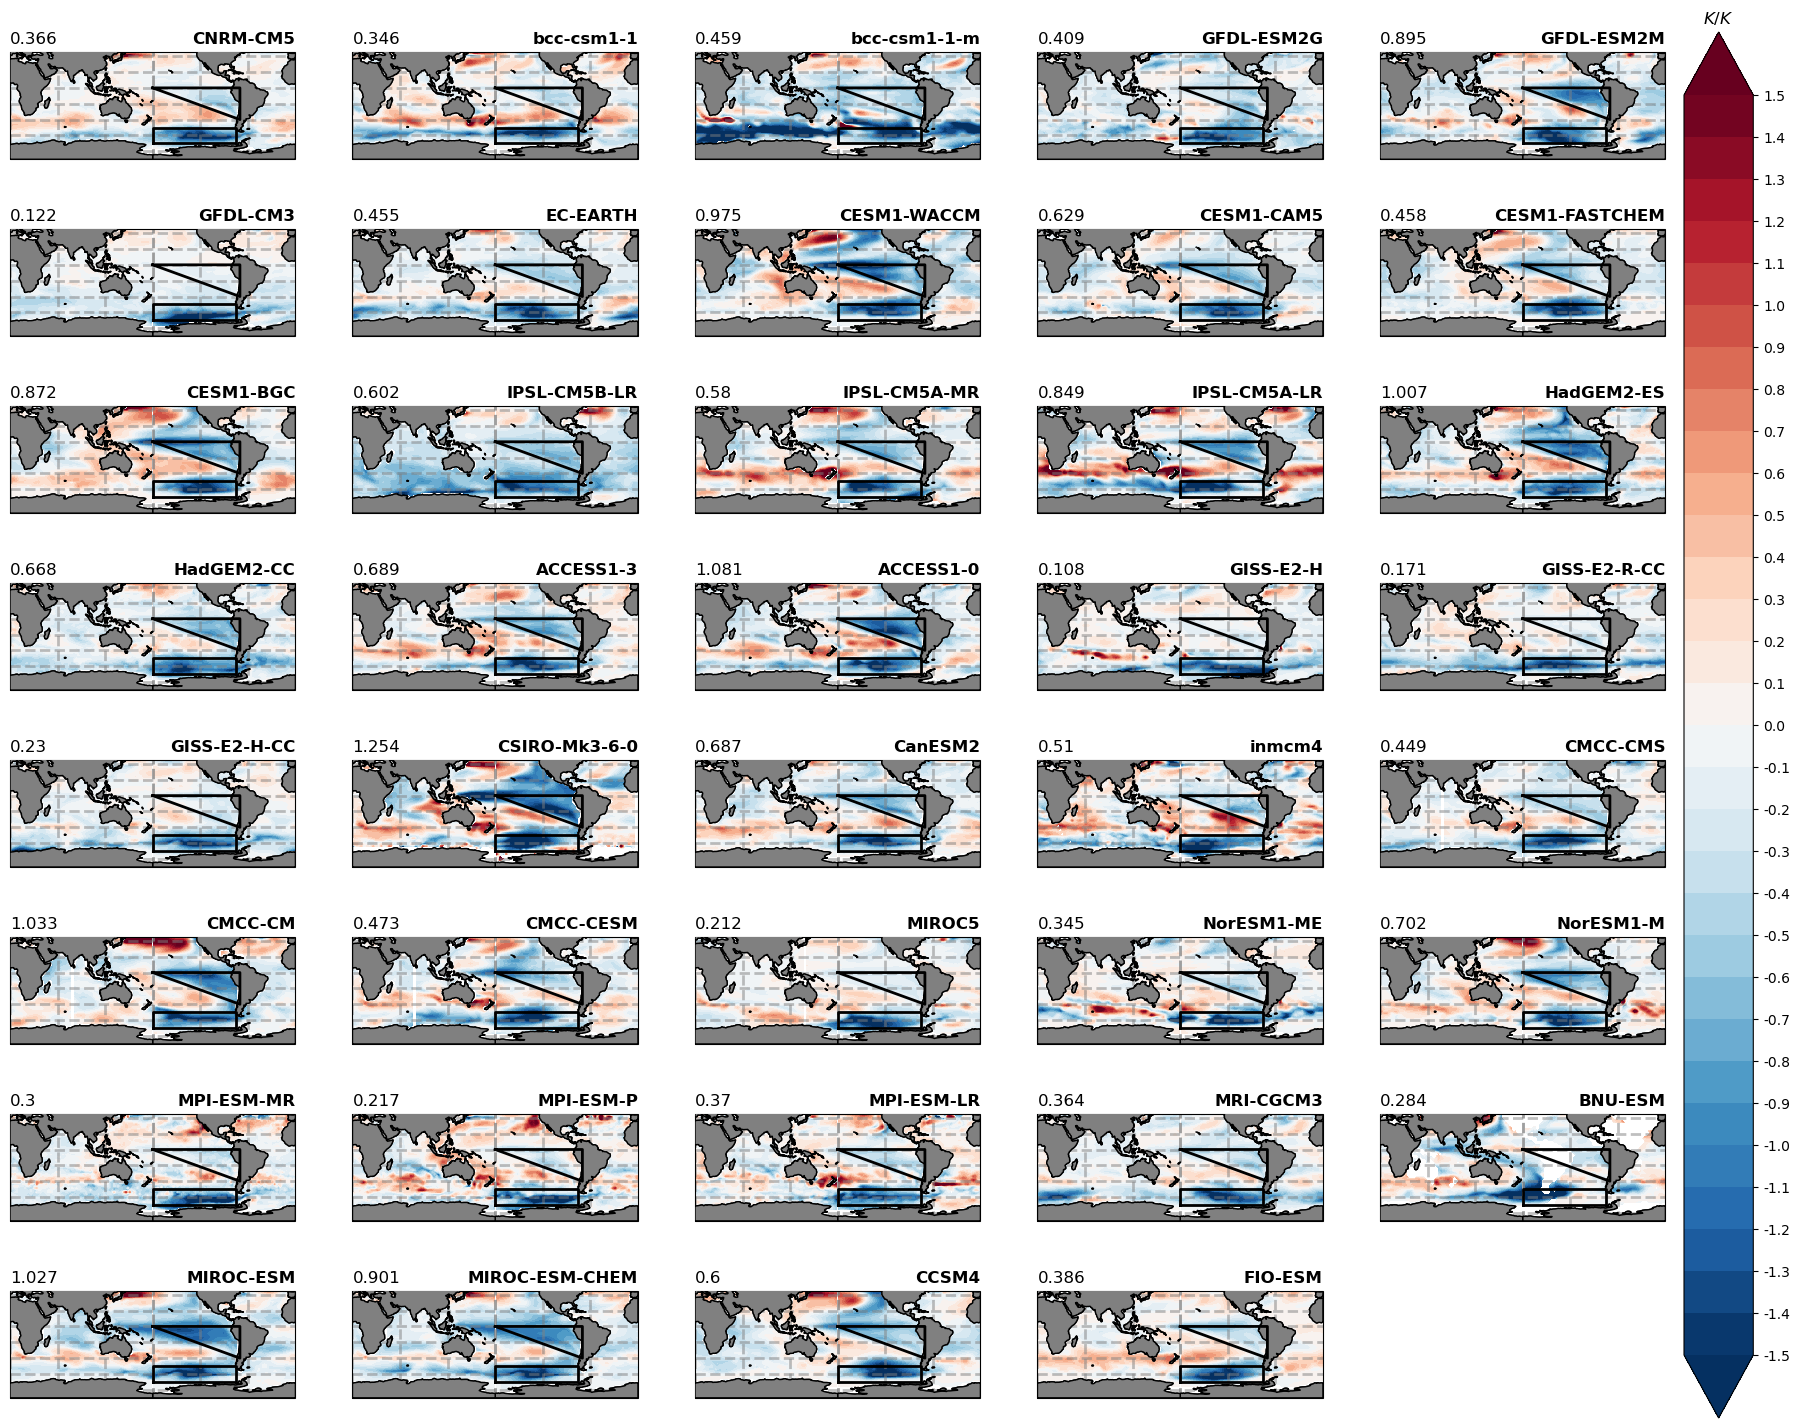

In [6]:
levels = np.arange(-1.5, 1.6, .1)
figure_SX(
    reg_so_dataset.sel(model=cmip5_models),
    rvalues_so_ept_coupling["reg"].sel(years=12*5, model=cmip5_models),
    levels, 
    cvar="reg_so_sst",
    include_winds=False, 
    ncols=5,
    save_name="/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_cmip5-so-ept")

# CMIP6 Maps

In [ ]:
levels = np.arange(-1.5, 1.6, .1)
figure_SX(
    reg_so_dataset.sel(model=cmip6_models),
    rvalues_so_ept_coupling["reg"].sel(years=12*5, model=cmip6_models),
    levels, 
    cvar="reg_so_sst",
    include_winds=False, 
    ncols=6,
    save_name="/home/espinosa10/SO-EP-teleconnection/Manuscript_Figures/SI/Figure_SX_cmip6-so-ept")

# Obs Maps